# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

"wget" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision.transforms import InterpolationMode

import optuna

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('data/', 
                       download = True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                          
                       ])
                      )
data_test = dset.SVHN('data/', split='test', 
                      download = True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [5]:
new = dset.SVHN('data/', split='test', 
                      download = True,          
                       )

Using downloaded and verified file: data/test_32x32.mat


In [6]:
data_test[0][0].shape

torch.Size([3, 32, 32])

In [7]:
q = transforms.ToTensor()
q(new[0][0])

tensor([[[0.1490, 0.1529, 0.1529,  ..., 0.1608, 0.1647, 0.1529],
         [0.1529, 0.1529, 0.1529,  ..., 0.1608, 0.1686, 0.1529],
         [0.1490, 0.1451, 0.1529,  ..., 0.1686, 0.1686, 0.1529],
         ...,
         [0.2039, 0.2078, 0.2000,  ..., 0.1725, 0.1725, 0.1608],
         [0.1961, 0.2000, 0.1922,  ..., 0.1725, 0.1765, 0.1647],
         [0.1882, 0.1882, 0.1804,  ..., 0.1686, 0.1725, 0.1647]],

        [[0.4039, 0.4078, 0.4078,  ..., 0.4000, 0.4039, 0.3804],
         [0.4078, 0.4078, 0.4078,  ..., 0.4000, 0.3961, 0.3804],
         [0.4118, 0.4078, 0.4157,  ..., 0.3961, 0.3922, 0.3804],
         ...,
         [0.4667, 0.4706, 0.4627,  ..., 0.4627, 0.4588, 0.4471],
         [0.4588, 0.4627, 0.4549,  ..., 0.4588, 0.4549, 0.4431],
         [0.4510, 0.4510, 0.4431,  ..., 0.4549, 0.4510, 0.4431]],

        [[0.2353, 0.2392, 0.2431,  ..., 0.2392, 0.2431, 0.2235],
         [0.2392, 0.2392, 0.2431,  ..., 0.2392, 0.2471, 0.2235],
         [0.2431, 0.2392, 0.2471,  ..., 0.2471, 0.2510, 0.

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [8]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [9]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [10]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            nn.Flatten(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [11]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    val_size = 0
    good_predict = 0
    model.eval() # Evaluation mode
    for i_step, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        good_predict += torch.sum(index == y)
        val_size += X.shape[0]
    
    accuracy =  float(good_predict)/val_size
    
    return accuracy
    
    
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    raise Exception("Not implemented")

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.420861, Train accuracy: 0.524554, Val accuracy: 0.678111
Average loss: 0.730125, Train accuracy: 0.777002, Val accuracy: 0.807112
Average loss: 0.614526, Train accuracy: 0.816913, Val accuracy: 0.816600
Average loss: 0.564348, Train accuracy: 0.833891, Val accuracy: 0.836325
Average loss: 0.529403, Train accuracy: 0.843617, Val accuracy: 0.826974


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [12]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [13]:
dir(train_aug_loader)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_index_sampler',
 '_is_protocol',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'check_worker_number_rationality',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_workers',
 'persistent_workers',
 'pin_memory',
 'pin_memory_device',
 'prefetch_factor',
 'sampler',
 'timeout',
 'worker_init_fn']

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

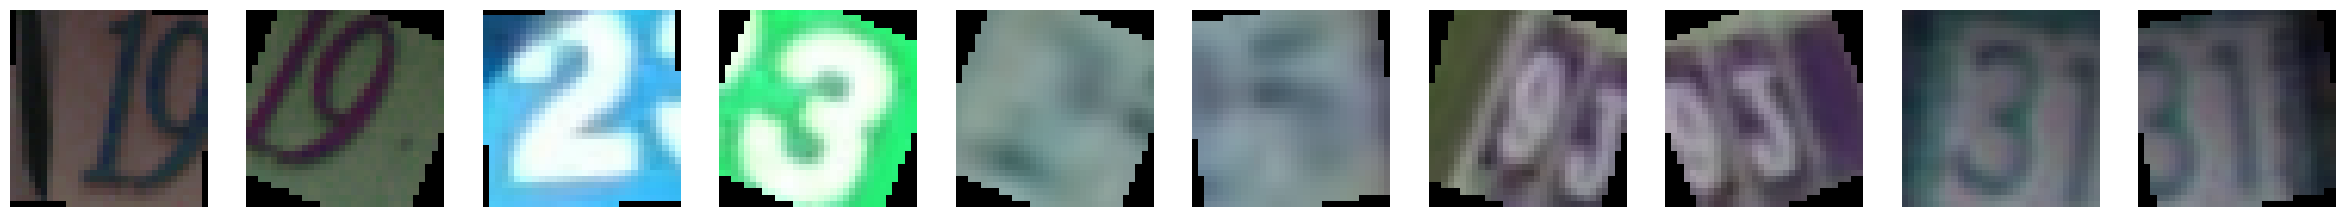

In [14]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    #transforms.RandomHorizontalFlip(),
   #transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
])

data_aug_vis = dset.SVHN('data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [15]:
# TODO: 
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = None

In [16]:
data_train = dset.SVHN('data/', 
                       download = True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                          
                       ])
                      )
data_train_trans =  dset.SVHN('data/', 
                       download = True,
                       transform=transforms.Compose([
                            transforms.ColorJitter(hue=.20, saturation=.20),
                            transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                    )

data_test = dset.SVHN('data/', split='test', 
                      download = True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [17]:
data_list = []

for num in train_sampler:
    X, y = data_train[num]
    data_list.append((X, y))
    X, y = data_train_trans[num]
    data_list.append((X, y))

In [18]:
train_loader = torch.utils.data.DataLoader(data_list, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [19]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            nn.Flatten(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [20]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.295433, Train accuracy: 0.565556, Val accuracy: 0.727391
Average loss: 0.768081, Train accuracy: 0.758941, Val accuracy: 0.806088
Average loss: 0.683362, Train accuracy: 0.787667, Val accuracy: 0.795850
Average loss: 0.638245, Train accuracy: 0.802136, Val accuracy: 0.827589
Average loss: 0.607504, Train accuracy: 0.811794, Val accuracy: 0.829431
Average loss: 0.586251, Train accuracy: 0.819464, Val accuracy: 0.818920
Average loss: 0.568567, Train accuracy: 0.823875, Val accuracy: 0.825677
Average loss: 0.555064, Train accuracy: 0.828823, Val accuracy: 0.847860
Average loss: 0.541858, Train accuracy: 0.832875, Val accuracy: 0.843628
Average loss: 0.535339, Train accuracy: 0.834386, Val accuracy: 0.837076


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [21]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [22]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.555445, Train accuracy: 0.468092, Val accuracy: 0.789229
Average loss: 0.614741, Train accuracy: 0.807955, Val accuracy: 0.845813
Average loss: 0.506912, Train accuracy: 0.842141, Val accuracy: 0.864105
Average loss: 0.452312, Train accuracy: 0.859426, Val accuracy: 0.881373
Average loss: 0.414634, Train accuracy: 0.871174, Val accuracy: 0.882738
Average loss: 0.385964, Train accuracy: 0.879517, Val accuracy: 0.883489
Average loss: 0.363094, Train accuracy: 0.886582, Val accuracy: 0.883830
Average loss: 0.345538, Train accuracy: 0.893006, Val accuracy: 0.881169
Average loss: 0.329264, Train accuracy: 0.897826, Val accuracy: 0.891816
Average loss: 0.314598, Train accuracy: 0.902365, Val accuracy: 0.888677


optuna-dashboard sqlite:///db.sqlite3# Подбор гиперпараметров

https://optuna.readthedocs.io/en/stable/tutorial/index.html

In [23]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

In [24]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

TypeError: must be real number, not NoneType

## Ищем оптимальные гиперпараметры с optuna

In [3]:
device = torch.device("cuda:0")

In [6]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_train = dset.SVHN('data/', 
                       download = True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                          
                       ])
                      )
data_train_trans =  dset.SVHN('data/', 
                       download = True,
                       transform=transforms.Compose([
                            transforms.ColorJitter(hue=.20, saturation=.20),
                            transforms.RandomRotation(30, interpolation=InterpolationMode.BILINEAR),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                    )

data_test = dset.SVHN('data/', split='test', 
                      download = True,
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_indices)
train_sampler = SubsetRandomSampler(train_indices)

data_list = []

for num in train_sampler:
    X, y = data_train[num]
    data_list.append((X, y))
    X, y = data_train_trans[num]
    data_list.append((X, y))

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [7]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        #print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    val_size = 0
    good_predict = 0
    model.eval() # Evaluation mode
    for i_step, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        good_predict += torch.sum(index == y)
        val_size += X.shape[0]
    
    accuracy =  float(good_predict)/val_size
    
    return accuracy

In [8]:
def make_model():
    lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10),
          )
    return lenet_model

In [24]:
def train_and_evaluet(param, model):
    train_loader = torch.utils.data.DataLoader(data_list, batch_size=param['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=param['batch_size'],
                                             sampler=val_sampler)
    model.type(torch.cuda.FloatTensor)
    model.to(device)
    
    loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
    optimizer = optim.SGD(model.parameters(), lr=param['lr'])
    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, param['epochs'])
    return val_history[-1]

In [25]:
def objective(trial):
     params = {
              'lr': trial.suggest_loguniform('learning_rate', 1e-5, 1e0),
              'epochs': trial.suggest_int("epochs", 20, 50),
              'batch_size': trial.suggest_int("batch_size", 32, 64)
              }
    
     model = make_model()
     accuracy = train_and_evaluet(params, model)

     return accuracy

In [26]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30)

[I 2023-01-26 21:16:13,120] A new study created in memory with name: no-name-47fa36b1-dfc2-4a60-9de4-e7f88e033d09
C:\Users\budni\AppData\Local\Temp\ipykernel_22952\4180604203.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lr': trial.suggest_loguniform('learning_rate', 1e-5, 1e0),
[I 2023-01-26 21:24:00,192] Trial 0 finished with value: 0.878028803494642 and parameters: {'learning_rate': 0.0034254678511851265, 'epochs': 43, 'batch_size': 56}. Best is trial 0 with value: 0.878028803494642.
[I 2023-01-26 21:27:41,121] Trial 1 finished with value: 0.8169408231520032 and parameters: {'learning_rate': 0.002980030663693968, 'epochs': 22, 'batch_size': 62}. Best is trial 0 with value: 0.878028803494642.
[I 2023-01-26 21:35:06,772] Trial 2 finished with value: 0.8917480035492458 and parameters: {'learning_rate': 0.005

# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = None

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0
print("Final test accuracy - ", final_test_accuracy)